In [17]:
#This block only works on Google Colab. On other environments, please use your own version(s) of -conda and -pip installs
!pip install lazypredict
import xgboost as xgb
import lightgbm as lgb

from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from scipy import stats

#Graph Settings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.layout_engine import TightLayoutEngine
from scipy import stats

#change graph colors here
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

#Pandas Display Settings
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 152

In [18]:
df = pd.read_csv('travis_dataset1.csv')

In [19]:

SFH_df = df[(df['location_landUse'] == 'Single Family Residential')
              | (df['location_landUse'] == 'Townhouse (Residential)')
              | (df['location_landUse'] == 'Row house (Residential)')
              | (df['location_landUse'] == 'Condominium Unit (Residential)')
              | (df['location_landUse'] == 'Apartments (generic)')
              | (df['location_landUse'] == 'Single Family Residential (Assumed)')
              | (df['location_landUse'] == 'Residential (General) (Single)')]

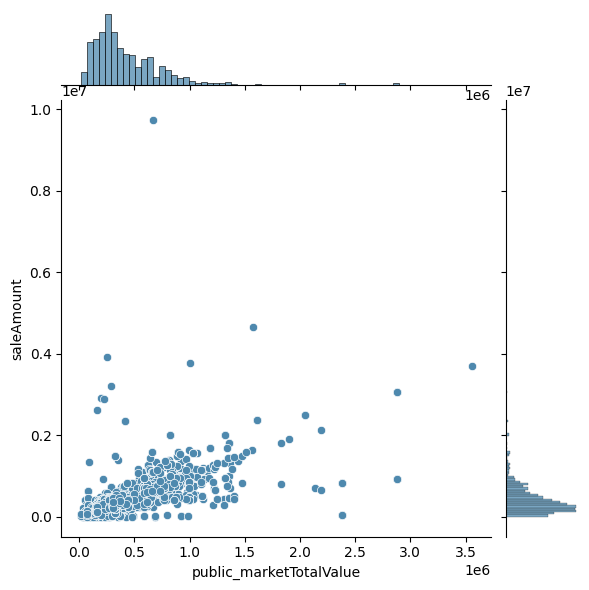

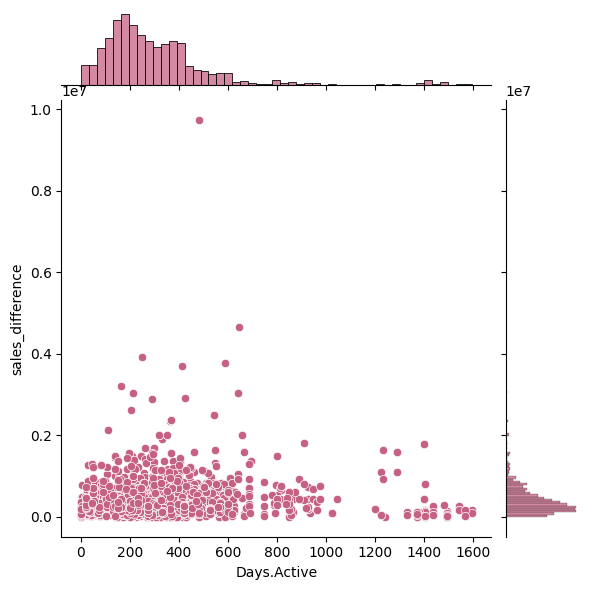

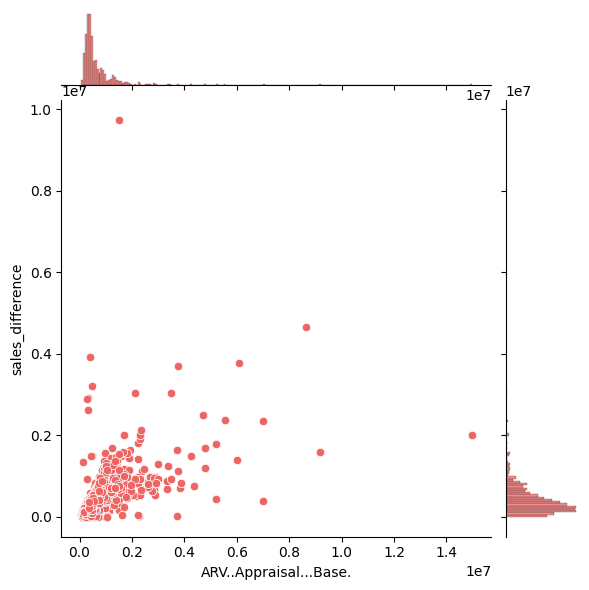

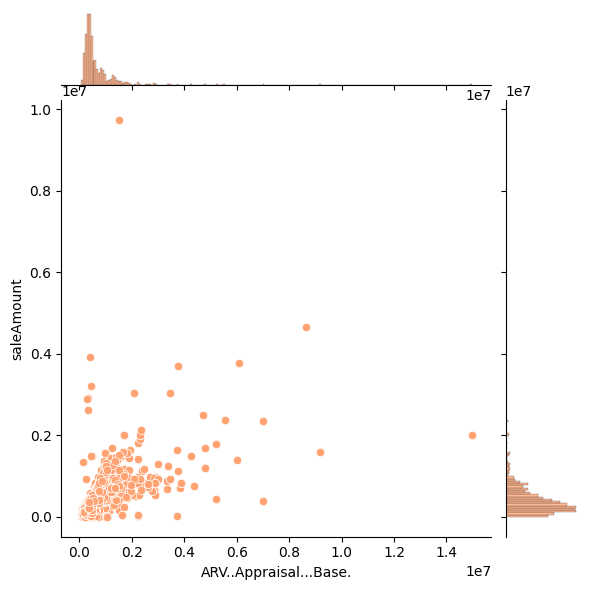

In [20]:

#drops 15% of data
SFH_df.dropna(subset=['Days.Active'], inplace=True)


SFH_df['sales_difference'] = SFH_df['saleAmount'] - SFH_df['Days.Active']
SFH_df['sales_difference_abs'] = abs(SFH_df['saleAmount'] - SFH_df['Days.Active'])

sns.jointplot(x='public_marketTotalValue', y='saleAmount', data=SFH_df, kind='scatter')
sns.jointplot(x='Days.Active', y='sales_difference', data=SFH_df, kind='scatter', color=custom_colors[1])

sns.jointplot(x='ARV..Appraisal...Base.', y='sales_difference', data=SFH_df, kind='scatter', color=custom_colors[2])
sns.jointplot(x='ARV..Appraisal...Base.', y='saleAmount', data=SFH_df, kind='scatter', color=custom_colors[3])


In [21]:
SFH_df = SFH_df[SFH_df['state'] != 'GA']
SFH_df = SFH_df[SFH_df['state'] != 'FL']
SFH_df = SFH_df[SFH_df['state'] != 'PA']
SFH_df = SFH_df[SFH_df['state'] != 'DE']
SFH_df = SFH_df[SFH_df['state'] != 'NC']
SFH_df = SFH_df[SFH_df['state'] != 'NJ']
print(SFH_df['state'].unique())

['MD' 'VA' 'DC']


In [22]:
def encode_states(df):
  #Encodes Maryland == 0 , Virginia = 1, DC = 2
  if df['state'] == 'MD':
    return 0
  elif df['state'] == 'VA':
    return 1
  elif df['state'] == 'DC':
    return 2

SFH_df['state_encode'] = SFH_df.apply(encode_states, axis=1)
print(SFH_df['state_encode'].unique())

[0 1 2]


In [23]:
X_cols=['state_encode', 'location_buildingArea', 'location_sumBuildingSqft', 'location_lotSizeSqft', 'location_bedrooms', 'location_totalRooms',
         'location_bathFull', 'location_bathsPartialNbr']
X = SFH_df[X_cols]
print(X.info)
print(X.dtypes)

<bound method DataFrame.info of       state_encode  location_buildingArea  location_sumBuildingSqft  \
1                0                   1476                      1476   
2                1                   1937                      1937   
3                1                   1937                      1937   
4                1                   1937                      1937   
5                2                   2800                      3290   
...            ...                    ...                       ...   
3228             0                   1196                      1196   
3229             0                   1196                      1196   
3230             1                   2169                      3009   
3231             1                   2169                      3009   
3237             1                   2456                      2456   

      location_lotSizeSqft  location_bedrooms  location_totalRooms  \
1                     6600                  3

In [24]:
y = np.log2(SFH_df['saleAmount'])
print(y.info)

<bound method Series.info of 1      16.95
2      17.04
3      17.84
4      16.76
5      18.71
        ... 
3228   17.76
3229   18.44
3230   19.24
3231   19.75
3237   19.25
Name: saleAmount, Length: 2445, dtype: float64>


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

lr = LinearRegression().fit(X_train, y_train)
coefs = [np.abs(x) for x in lr.coef_]

print(f'y-intercept: {lr.intercept_}')

coef_labels = ['State', 'Building Area (Sqft)', 'Interior Area (SqFt)', 'Lot Size (Sqft)', 'Bedrooms', 'Total Rooms', 'Full Bathrooms', 'Partial Bathrooms']
for idx, coef in enumerate(coefs):
  formatted_coef = format(coef, 'f')
  print(f'{coef_labels[idx]}: {formatted_coef}')

y-intercept: 16.72165092586321
State: 0.872343
Building Area (Sqft): 0.000292
Interior Area (SqFt): 0.000012
Lot Size (Sqft): 0.000004
Bedrooms: 0.175752
Total Rooms: 0.026676
Full Bathrooms: 0.366901
Partial Bathrooms: 0.292587


In [26]:
y_pred = lr.predict(X_test)
linear_df = pd.DataFrame({"Actual": y_test, 'Predicted': y_train})
linear_df.head()

print("Abs Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Sq Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Sq Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Abs Error: 0.9270001497369379
Sq Error: 2.0814846822525217
Root Mean Sq Error: 1.4427351393282557


In [27]:

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet

from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r2
from termcolor import colored as cl

#Ridge
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

print("Ridge Abs Error:", metrics.mean_absolute_error(y_test, ridge_yhat))
print("Ridge Sq Error:", metrics.mean_squared_error(y_test, ridge_yhat))
print("Ridge Root Mean Sq Error:", np.sqrt(metrics.mean_squared_error(y_test, ridge_yhat)))

#Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

print("\n")
print("Lasso Abs Error:", metrics.mean_absolute_error(y_test, lasso_yhat))
print("Lasso Sq Error:", metrics.mean_squared_error(y_test, lasso_yhat))
print("Lasso Root Mean Sq Error:", np.sqrt(metrics.mean_squared_error(y_test, lasso_yhat)))

#Bayesian
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

print("\n")
print("Bayesian Abs Error:", metrics.mean_absolute_error(y_test, bayesian_yhat))
print("Bayesian Sq Error:", metrics.mean_squared_error(y_test, bayesian_yhat))
print("Bayesian Root Mean Sq Error:", np.sqrt(metrics.mean_squared_error(y_test, bayesian_yhat)))

#ElasticNet
en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

print("\n")
print("ElasticNet Abs Error:", metrics.mean_absolute_error(y_test, en_yhat))
print("ElasticNet Sq Error:", metrics.mean_squared_error(y_test, en_yhat))
print("ElasticNet Root Mean Sq Error:", np.sqrt(metrics.mean_squared_error(y_test, en_yhat)))


Ridge Abs Error: 0.926906104862534
Ridge Sq Error: 2.0813197087117175
Ridge Root Mean Sq Error: 1.4426779643121044


Lasso Abs Error: 0.922782628285244
Lasso Sq Error: 2.0758287657732475
Lasso Root Mean Sq Error: 1.440773669169883


Bayesian Abs Error: 0.9242015222206497
Bayesian Sq Error: 2.076461595714858
Bayesian Root Mean Sq Error: 1.440993267060904


ElasticNet Abs Error: 0.923297716267123
ElasticNet Sq Error: 2.0757299429868095
ElasticNet Root Mean Sq Error: 1.4407393737199


In [28]:
# EVALUATION

# 1. Explained Variance Score

print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, y_pred)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')


EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.19050539805266709
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.19056821891015374
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.19266089904184458
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.19241664858860286
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.19269715149895428
-------------------------------------------------------------------------------


In [29]:
# 2. R-squared

print(cl('R-SQUARED:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of OLS model is {}'.format(r2(y_test, y_pred)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Ridge model is {}'.format(r2(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Lasso model is {}'.format(r2(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Bayesian model is {}'.format(r2(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of ElasticNet is {}'.format(r2(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

R-SQUARED:
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.18967562904318536
-------------------------------------------------------------------------------
R-Squared of Ridge model is 0.18973985343158295
-------------------------------------------------------------------------------
R-Squared of Lasso model is 0.19187748380691694
-------------------------------------------------------------------------------
R-Squared of Bayesian model is 0.1916311223857976
-------------------------------------------------------------------------------
R-Squared of ElasticNet is 0.19191595563087016
-------------------------------------------------------------------------------


In [30]:
coef_labels = ['State', 'Building Area (Sqft)', 'Interior Area (SqFt)', 'Lot Size (Sqft)', 'Bedrooms', 'Total Rooms', 'Full Bathrooms', 'Partial Bathrooms']

#Inference Function
def make_inference(array):
  '''Makes a single inference on an array from all trained models'''
  np_array = np.array(array).reshape(1,-1)

  return_dict = {}

  linear_pred = lr.predict(np_array)
  ridge_pred = ridge.predict(np_array)
  lasso_pred = lasso.predict(np_array)
  bayes_pred = bayesian.predict(np_array)
  elasticNet_pred = en.predict(np_array)

  return_dict['Linear Model:'] = float(2)**(float(linear_pred[0]))
  return_dict['Ridge Model:'] = float(2)**(float(ridge_pred[0]))
  return_dict['Lasso Model:'] = float(2)**(float(lasso_pred[0]))
  return_dict['Bayes Model:'] = float(2)**(float(bayes_pred[0]))
  return_dict['ElasticNet Model:'] = float(2)**(float(elasticNet_pred[0]))

  avg = 0
  for val in return_dict.values():
    avg += val
  avg = avg / len(return_dict)

  return return_dict, avg


print(make_inference([0, 1088, 1088, 871.20, 3, 5, 2, 0])) #https://www.zillow.com/homedetails/1335-James-St-Baltimore-MD-21223/36533423_zpid/


({'Linear Model:': 140772.82698681887, 'Ridge Model:': 140891.40403929364, 'Lasso Model:': 148365.61896512497, 'Bayes Model:': 144642.62321778113, 'ElasticNet Model:': 146777.29496395958}, 144289.95363459564)


This code blocks makes (good) inferences on houses:

Baltimore (0)

https://www.zillow.com/homedetails/401-S-Dean-St-Baltimore-MD-21224/36559977_zpid/

Virginia(1)

https://www.zillow.com/homedetails/3873-Havenwood-Pl-SUITE-D-Alexandria-VA-22309/2054089965_zpid/

DC(2)

https://www.zillow.com/homedetails/3319-11th-St-NW-2-Washington-DC-20010/2057350288_zpid/

In [31]:
#Baltimore (0)

print(make_inference([0, 788, 788, 567, 2, 4, 2, 0]))

({'Linear Model:': 152683.44132386098, 'Ridge Model:': 152789.733076654, 'Lasso Model:': 159036.21912581814, 'Bayes Model:': 156140.46004790234, 'ElasticNet Model:': 157833.42499221573}, 155696.65571329024)


In [32]:
#Virginia (1)
print(make_inference([1, 1100, 1100, 1100, 2, 4, 1, 1]))

({'Linear Model:': 282482.4766500055, 'Ridge Model:': 282461.0560574024, 'Lasso Model:': 279670.8273632198, 'Bayes Model:': 281781.4168447329, 'ElasticNet Model:': 280687.8958061647}, 281416.734544305)


In [33]:
#DC (2)
print(make_inference([2, 728, 728, 728, 2, 4, 1, 1]))

({'Linear Model:': 480591.8450883908, 'Ridge Model:': 480185.03599110834, 'Lasso Model:': 456360.9567054527, 'Bayes Model:': 467652.7937209016, 'ElasticNet Model:': 461075.7413361241}, 469173.2745683955)


The following are bad model prediction examples:
1. https://www.zillow.com/homedetails/933-Hillside-Rd-LOT-A-Lutherville-Timonium-MD-21093/2066503939_zpid/?  (no upper cap for lot size)

2. Hood house https://www.zillow.com/homedetails/2419-Baker-St-Baltimore-MD-21216/36505517_zpid/

In [34]:
print(make_inference([0, 9500, 9500, 903870, 6, 15, 6, 3]))

({'Linear Model:': 30614645.078999955, 'Ridge Model:': 30613997.418097023, 'Lasso Model:': 30532235.182267807, 'Bayes Model:': 30589382.669707153, 'ElasticNet Model:': 30561056.846352458}, 30582263.439084876)


In [35]:
print(make_inference([0, 900, 0, 1544, 3, 4, 1, 0]))

({'Linear Model:': 108238.7148975972, 'Ridge Model:': 108300.24576828872, 'Lasso Model:': 113101.99035553029, 'Bayes Model:': 110243.55814578735, 'ElasticNet Model:': 111809.89162371852}, 110338.88015818442)
